In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import auc, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

from SepMe.processing.batchprocessing import *

import warnings
warnings.filterwarnings('ignore')

SepMe - INFO - MLFLOW_TRACKING_URI - http://localhost:5000


In [45]:
df = pd.read_csv('lazy_all.csv')
print(df.columns)

df['human_bin'] = 'no'
df.loc[(df['human_rating'].between(50,100)), 'human_bin'] = 'yes'

df['expert_bin'] = 'maybe'
df.loc[(df['M'].isin([4,5])) & (df['A'].isin([4,5])), 'expert_bin'] = 'yes'
df.loc[(df['M'].isin([1,2])) & (df['A'].isin([1,2])), 'expert_bin'] = 'no'



#df['M'] = minmax_scale(df['M'])
#df['A'] = minmax_scale(df['A'])
df['human_rating'] = minmax_scale(df['human_rating'])


df = df.loc[df['1v1']==False]

Index(['filename', 'type', '1v1', 'phase', 'human_rating', 'idx', 'pass',
       'as_0.02_ce', 'as_0.02_cp', 'as_0.02_ltcc', 'as_0.05_ce', 'as_0.05_cp',
       'as_0.05_ltcc', 'as_0.1_ce', 'as_0.1_cp', 'as_0.1_ltcc', 'as_0.5_ce',
       'as_0.5_cp', 'as_0.5_ltcc', 'bt_0.02_cp', 'bt_0.02_ltcc', 'bt_0.05_ce',
       'bt_0.05_cp', 'bt_0.05_ltcc', 'bt_0.1_ce', 'bt_0.1_cp', 'bt_0.1_ltcc',
       'bt_0.5_ce', 'bt_0.5_cp', 'bt_0.5_ltcc', 'cbsg_0.1_ce', 'cbsg_0.1_cp',
       'cbsg_0.1_ltcc', 'cbsg_0.2_ce', 'cbsg_0.2_cp', 'cbsg_0.2_ltcc',
       'cbsg_0.5_ce', 'cbsg_0.5_cp', 'cbsg_0.5_ltcc', 'cbsg_2.0_ce',
       'cbsg_2.0_cp', 'cbsg_2.0_ltcc', 'del_n/a_ce', 'del_n/a_cp',
       'del_n/a_ltcc', 'del_n/a_mv_false', 'del_n/a_mv_true', 'knn_1.0_ce',
       'knn_1.0_cp', 'knn_1.0_ltcc', 'knn_2.0_ce', 'knn_2.0_cp',
       'knn_2.0_ltcc', 'knn_4.0_ce', 'knn_4.0_cp', 'knn_4.0_ltcc',
       'knn_6.0_ce', 'knn_6.0_cp', 'knn_6.0_ltcc', 'knn_8.0_ce', 'knn_8.0_cp',
       'knn_8.0_ltcc', 'index', 'M', 'A',

In [46]:
#reproducing old sepme
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95


def bootstrap_aoc(df, bs=100, sample=1000, target_col='human_bin'):
    
    aucs = {}
    for col in df.columns[7:-2]:

        if df[col].dtype =='float64':
            #print(col)
            df.loc[:, 'a'] = 1 - df[col]
            a = np.array(df.loc[:,target_col].copy())
            b = np.array(df.loc[:, 'a'].copy())

            stuff =[]
            for i in range(bs):
                idx = random.sample(list(np.arange(len(a))),sample)
                stuff.append(roc_auc_score(a[idx],b[idx]))

            n = len(stuff)
            m = mean(stuff)
            std_err = sem(stuff)
            h = std_err * t.ppf((1 + confidence) / 2, n - 1)

            aucs[col] = {}
            aucs[col]['mean'] = m
            aucs[col]['start'] = m-h
            aucs[col]['end'] = m+h
            
            if aucs[col]['mean']>.82:
                print(col)
                b = np.array(df.loc[:, [col,'a']].copy())
                skplt.metrics.plot_roc(a,b)
                plt.show()



    aucs = pd.DataFrame.from_dict(aucs, orient='index').reset_index()
    aucs.columns = ['type','value','ci-','ci+'] 
    aucs = aucs.sort_values('value', ascending=False)
    aucs['spread'] = aucs['ci+'] -aucs['ci-']
    return aucs


In [68]:
# df_exp = df.loc[(df['expert_bin'].isin(['yes','no']))]
# print(df_exp.shape)
# aucs_human = bootstrap_aoc(df_exp, target_col='expert_bin')
# aucs_human.head(20)



df_bin = df.loc[(df['human_rating'].between(0,.50)) | (df['human_rating'].between(.50,1.00))]
print(df_bin.shape)
aucs_human = bootstrap_aoc(df_bin, target_col='human_bin')
aucs_human.head(20)

(16277, 68)


,type,value,ci-,ci+,spread
14,bt_0.05_ce,0.694612,0.691258,0.697965,0.006706
17,bt_0.1_ce,0.694285,0.691120,0.697450,0.006329
9,as_0.5_ce,0.693733,0.690674,0.696792,0.006118
0,as_0.02_ce,0.692492,0.689076,0.695907,0.006831
6,as_0.1_ce,0.691120,0.687706,0.694533,0.006827
35,del_n/a_ce,0.690750,0.687180,0.694320,0.007141
49,knn_6.0_ce,0.689821,0.686533,0.693109,0.006576
3,as_0.05_ce,0.689145,0.686054,0.692235,0.006181
26,cbsg_0.2_ce,0.688655,0.685303,0.692007,0.006704
46,knn_4.0_ce,0.688089,0.684593,0.691584,0.006991


In [44]:

print(df.shape)
aucs_human = bootstrap_aoc(df, target_col='M')
aucs_human.head(20)

(28205, 68)


ValueError: multi_class must be in ('ovo', 'ovr')

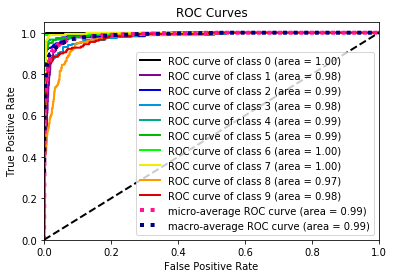

[0 1 2 ... 8 9 8]
[[1.00000000e+000 1.06266396e-076 3.58203829e-166 ... 1.70169535e-084
  4.80877086e-116 2.83961827e-066]
 [0.00000000e+000 9.99999997e-001 1.58790269e-026 ... 0.00000000e+000
  3.38270485e-009 1.41987749e-041]
 [0.00000000e+000 1.47690284e-011 2.70900969e-018 ... 0.00000000e+000
  1.00000000e+000 6.24368860e-069]
 ...
 [0.00000000e+000 4.66713719e-003 1.02781458e-023 ... 0.00000000e+000
  9.95332863e-001 4.92047140e-053]
 [0.00000000e+000 5.47962341e-008 1.89399156e-041 ... 0.00000000e+000
  2.24728210e-013 9.99999945e-001]
 [0.00000000e+000 1.47780253e-101 3.54154881e-020 ... 0.00000000e+000
  1.00000000e+000 1.72725366e-043]]
(1797,)
(1797, 10)


In [40]:
"""
An example showing the plot_roc_curve method
used by a scikit-learn classifier
"""
from __future__ import absolute_import
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits as load_data
import scikitplot as skplt


X, y = load_data(return_X_y=True)
nb = GaussianNB()
nb.fit(X, y)
probas = nb.predict_proba(X)
skplt.metrics.plot_roc(y_true=y, y_probas=probas)
plt.show()



print(y)
print(probas)
print(y.shape)
print(probas.shape)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
28200    1.0
28201    1.0
28202    1.0
28203    1.0
28204    1.0
Name: M, Length: 28205, dtype: float64
[[0.07657729 0.07657729 0.07657729 0.07657729 0.07657729]
 [0.07657729 0.07657729 0.07657729 0.07657729 0.07657729]
 [0.07657729 0.07657729 0.07657729 0.07657729 0.07657729]
 ...
 [0.06123802 0.06123802 0.06123802 0.06123802 0.06123802]
 [0.06123802 0.06123802 0.06123802 0.06123802 0.06123802]
 [0.06123802 0.06123802 0.06123802 0.06123802 0.06123802]]
(28205,)
(28205, 5)


ValueError: continuous format is not supported

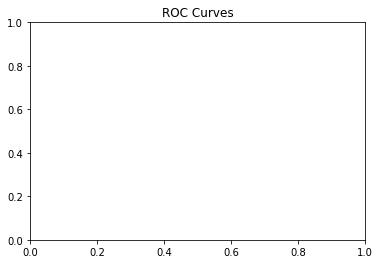

In [42]:
def multiclass_roc(df, target_col= 'M', col='as_0.02_ce'):
    y = df[target_col]
    probas = np.tile(np.array(df[col]), [5,1]).T
    
    print(y)
    print(probas)
    print(y.shape)
    print(probas.shape)
    skplt.metrics.plot_roc(y_true=y, y_probas=probas)
    
multiclass_roc(df, target_col= 'M', col='as_0.02_ce')   


In [34]:
df.columns

Index(['filename', 'type', '1v1', 'phase', 'human_rating', 'idx', 'pass',
       'as_0.02_ce', 'as_0.02_cp', 'as_0.02_ltcc', 'as_0.05_ce', 'as_0.05_cp',
       'as_0.05_ltcc', 'as_0.1_ce', 'as_0.1_cp', 'as_0.1_ltcc', 'as_0.5_ce',
       'as_0.5_cp', 'as_0.5_ltcc', 'bt_0.02_cp', 'bt_0.02_ltcc', 'bt_0.05_ce',
       'bt_0.05_cp', 'bt_0.05_ltcc', 'bt_0.1_ce', 'bt_0.1_cp', 'bt_0.1_ltcc',
       'bt_0.5_ce', 'bt_0.5_cp', 'bt_0.5_ltcc', 'cbsg_0.1_ce', 'cbsg_0.1_cp',
       'cbsg_0.1_ltcc', 'cbsg_0.2_ce', 'cbsg_0.2_cp', 'cbsg_0.2_ltcc',
       'cbsg_0.5_ce', 'cbsg_0.5_cp', 'cbsg_0.5_ltcc', 'cbsg_2.0_ce',
       'cbsg_2.0_cp', 'cbsg_2.0_ltcc', 'del_n/a_ce', 'del_n/a_cp',
       'del_n/a_ltcc', 'del_n/a_mv_false', 'del_n/a_mv_true', 'knn_1.0_ce',
       'knn_1.0_cp', 'knn_1.0_ltcc', 'knn_2.0_ce', 'knn_2.0_cp',
       'knn_2.0_ltcc', 'knn_4.0_ce', 'knn_4.0_cp', 'knn_4.0_ltcc',
       'knn_6.0_ce', 'knn_6.0_cp', 'knn_6.0_ltcc', 'knn_8.0_ce', 'knn_8.0_cp',
       'knn_8.0_ltcc', 'index', 'M', 'A',

In [7]:
df['consensus'] = 'no'
df.loc[(df['human_bin']=='yes') & (df['expert_bin']=='yes'), 'consensus'] = 'yes'
df.loc[(df['human_bin']=='no') & (df['expert_bin']=='no'), 'consensus'] = 'yes'
df['consensus'].value_counts()

no     14620
yes    13585
Name: consensus, dtype: int64

In [8]:
df['consensus'] = 'no'
df.loc[(df['human_bin']=='yes') & (df['expert_bin']=='yes'), 'consensus'] = 'yes'
#df.loc[(df['human_bin']=='no') & (df['expert_bin']=='no'), 'consensus'] = 'yes'
df['consensus'].value_counts()


no     21271
yes     6934
Name: consensus, dtype: int64

In [9]:
df.loc[df['class']==1]

,filename,type,1v1,phase,human_rating,idx,pass,as_0.02_ce,as_0.02_cp,as_0.02_ltcc,...,knn_8.0_ce,knn_8.0_cp,knn_8.0_ltcc,index,M,A,class,human_bin,expert_bin,consensus
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.17,JavierGeneratedData_3dinterleaved_3classes_Gli...,0.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,no,yes,no
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.21,JavierGeneratedData_3dinterleaved_3classes_Gli...,0.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,no,yes,no
2,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.78,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,yes,yes,yes
3,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.86,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,yes,yes,yes
4,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.85,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28120,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,True,training,0.85,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.000000,...,0.018563,0.987805,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,1.0,1,yes,yes,yes
28121,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,True,training,0.55,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.000000,...,0.018563,0.987805,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,1.0,1,yes,yes,yes
28122,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,True,training,0.32,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,0.0,0.083975,0.948282,1.000000,...,0.018563,0.987805,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,1.0,1,no,yes,no
28123,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,True,training,0.64,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.000000,...,0.018563,0.987805,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,1.0,1,yes,yes,yes


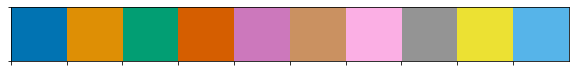

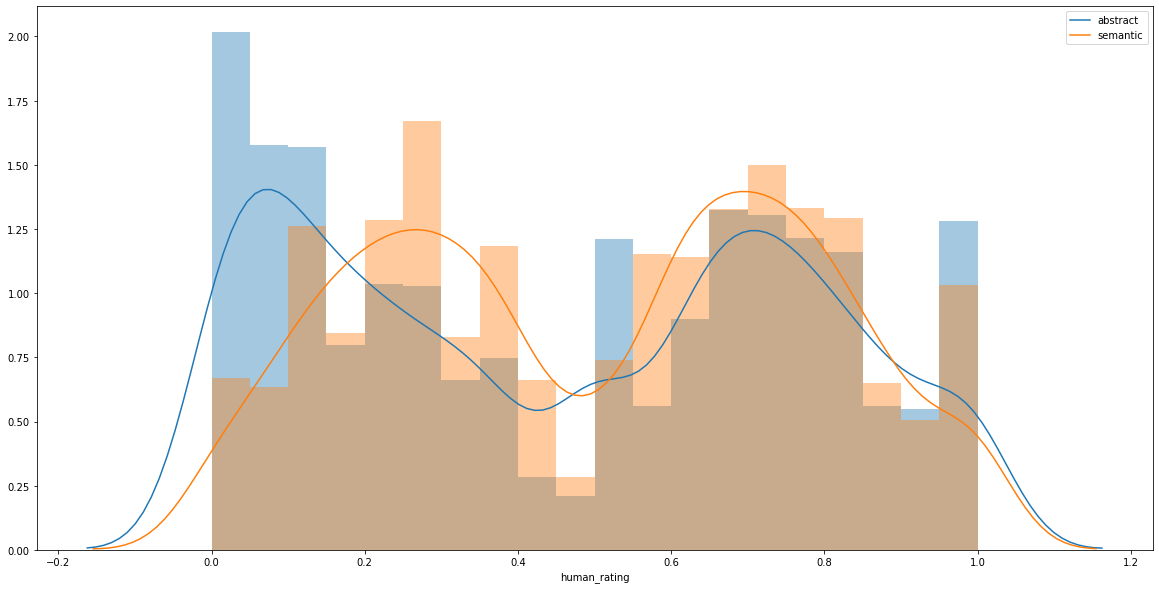

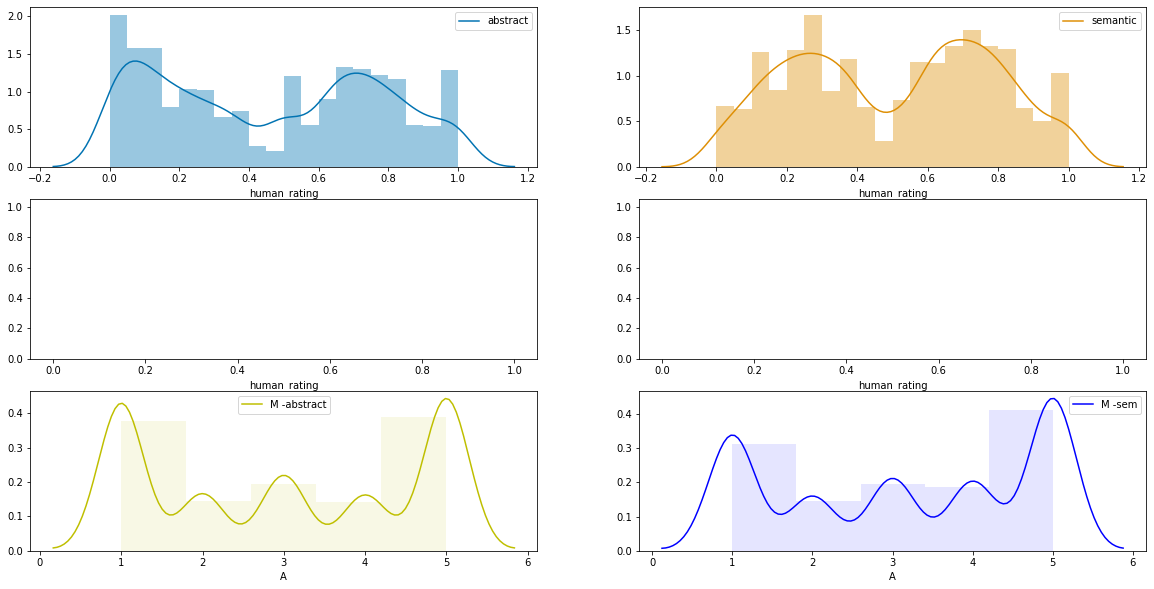

In [67]:
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)



def get_dfs(df):
    df1 = select_df(df, kind="abstract", phase="task", versus=False)
    df2 = select_df(df, kind="semantic", phase="task", versus=False)
    df3 = select_df(df, kind="abstract", phase="task", versus=True)
    df4 = select_df(df, kind="semantic", phase="task", versus=True)

    return df1,df2,df3,df4


df1,df2,df3,df4 = get_dfs(df)

fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df1.human_rating, bins=20, kde_kws={"label": "abstract"})
sns.distplot(df2.human_rating, bins=20, kde_kws={"label": "semantic"})

sns.distplot(df3.human_rating, bins=20, kde_kws={"label": "1v1 - abstract"})
sns.distplot(df4.human_rating, bins=20, kde_kws={"label": "1v1 - semantic"})

# sns.distplot(df1.M, bins=5, color='y', hist_kws=dict(alpha=.1), kde_kws={"label": "M -abstract"})
# sns.distplot(df2.M, bins=5, color='b', hist_kws=dict(alpha=.1), kde_kws={"label": "M -sem"})
# sns.distplot(df3.A, bins=5, color='y', hist_kws=dict(alpha=.1), kde_kws={"label": "A -abstract -1v1"})
# sns.distplot(df4.A, bins=5, color='b', hist_kws=dict(alpha=.1), kde_kws={"label": "A -sem -1v1"})




fig, ax = plt.subplots(3,2, figsize=(20,10))
sns.distplot(df1.human_rating, bins=20, kde_kws={"label": "abstract"}, ax=ax[0,0], color = current_palette[0])
sns.distplot(df2.human_rating, bins=20, kde_kws={"label": "semantic"}, ax=ax[0,1], color = current_palette[1])

sns.distplot(df3.human_rating, bins=20, kde_kws={"label": "1v1 - abstract"}, ax=ax[1,0], color = current_palette[2])
sns.distplot(df4.human_rating, bins=20, kde_kws={"label": "1v1 - semantic"}, ax=ax[1,1], color = current_palette[3])




sns.distplot(df1.M, bins=5, color='y', hist_kws=dict(alpha=.1), kde_kws={"label": "M -abstract"}, ax=ax[2,0])
sns.distplot(df2.M, bins=5, color='b', hist_kws=dict(alpha=.1), kde_kws={"label": "M -sem"}, ax=ax[2,1])
sns.distplot(df3.A, bins=5, color='y', hist_kws=dict(alpha=.1), kde_kws={"label": "A -abstract -1v1"}, ax=ax[2,0])
sns.distplot(df4.A, bins=5, color='b', hist_kws=dict(alpha=.1), kde_kws={"label": "A -sem -1v1"}, ax=ax[2,1])




In [11]:
df

,filename,type,1v1,phase,human_rating,idx,pass,as_0.02_ce,as_0.02_cp,as_0.02_ltcc,...,knn_8.0_ce,knn_8.0_cp,knn_8.0_ltcc,index,M,A,class,human_bin,expert_bin,consensus
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.17,JavierGeneratedData_3dinterleaved_3classes_Gli...,0.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,no,yes,no
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.21,JavierGeneratedData_3dinterleaved_3classes_Gli...,0.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,no,yes,no
2,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.78,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,yes,yes,yes
3,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.86,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,yes,yes,yes
4,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.85,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,1.0,1,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28200,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,True,training,0.24,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,1.0,2,no,yes,no
28201,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,True,training,0.11,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,1.0,2,no,yes,no
28202,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,True,training,1.00,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,1.0,2,yes,yes,yes
28203,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,True,training,0.00,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,1.0,2,no,yes,no


In [49]:
## normalize df by scenario

dd = df.copy()
for tt in set(df['type']):
    for vv in set(df['1v1']):
        print(tt + str(vv))
        dd.loc[(df['type']==tt) & (df['1v1']==vv), 'human_rating'] = minmax_scale(df.loc[(df['type']==tt) & (df['1v1']==vv), 'human_rating'])

dd



abstractFalse
semanticFalse


,filename,type,1v1,phase,human_rating,idx,pass,as_0.02_ce,as_0.02_cp,as_0.02_ltcc,...,knn_6.0_ltcc,knn_8.0_ce,knn_8.0_cp,knn_8.0_ltcc,index,M,A,class,human_bin,expert_bin
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.17,JavierGeneratedData_3dinterleaved_3classes_Gli...,0.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,no,yes
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.21,JavierGeneratedData_3dinterleaved_3classes_Gli...,0.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,no,yes
2,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.78,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes
3,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.86,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes
4,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.85,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28180,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,1.00,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,1.000000,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28181,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.97,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,1.000000,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28182,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.83,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,1.000000,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28183,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.60,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,1.000000,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes


In [50]:
df_agg = (df.groupby(['filename','type','1v1','phase'])
     .agg({'human_rating':['mean', 'count', sem], 
           'M':'first', 'A':'first', 'pass':'sum',
          'as_0.1_ce':['mean', sem]}))

df_agg.columns = ["%s%s" % (a, ".%s" % b if b else "") for a, b in df_agg.columns]

df_agg = df_agg.reset_index()
print(len(set(df_agg.filename)))
df_agg

114


,filename,type,1v1,phase,human_rating.mean,human_rating.count,human_rating.sem,M.first,A.first,pass.sum,as_0.1_ce.mean,as_0.1_ce.sem
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.807250,40,0.017071,5,5,40.0,0.071447,0.000821
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.689444,36,0.043201,5,5,30.0,0.071447,0.000867
2,JavierGeneratedData_3dinterleaved_4classes_PCA,abstract,False,training,0.706833,60,0.025334,4,5,51.0,0.159766,0.002993
3,JavierGeneratedData_3dinterleaved_4classes_PCA,semantic,False,training,0.578667,60,0.028143,4,5,60.0,0.159766,0.002993
4,JavierGeneratedData_3dinterleaved_4classes_RobPCA,abstract,False,task,0.660333,60,0.030517,4,5,54.0,0.195328,0.002896
...,...,...,...,...,...,...,...,...,...,...,...,...
225,worldmap_PCA,semantic,False,task,0.461458,48,0.044079,5,5,43.0,0.260689,0.001349
226,worldmap_RobPCA,abstract,False,task,0.564573,164,0.025169,5,5,133.0,0.211759,0.003051
227,worldmap_RobPCA,semantic,False,task,0.529000,80,0.031625,5,5,68.0,0.211759,0.004382
228,yeast_PCA,abstract,False,task,0.302187,160,0.021392,1,1,117.0,0.436849,0.002852


,filename,type,1v1,phase,human_rating.mean,human_rating.count,human_rating.sem,M.first,A.first,pass.sum,as_0.1_ce.mean,as_0.1_ce.sem,start,end,spread
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.807250,40,0.017071,5,5,40.0,0.071447,0.000821,0.772721,0.841779,0.069057
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.689444,36,0.043201,5,5,30.0,0.071447,0.000867,0.601741,0.777147,0.175406
2,JavierGeneratedData_3dinterleaved_4classes_PCA,abstract,False,training,0.706833,60,0.025334,4,5,51.0,0.159766,0.002993,0.656139,0.757528,0.101388
3,JavierGeneratedData_3dinterleaved_4classes_PCA,semantic,False,training,0.578667,60,0.028143,4,5,60.0,0.159766,0.002993,0.522354,0.634980,0.112626
4,JavierGeneratedData_3dinterleaved_4classes_RobPCA,abstract,False,task,0.660333,60,0.030517,4,5,54.0,0.195328,0.002896,0.599269,0.721398,0.122129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,worldmap_PCA,semantic,False,task,0.461458,48,0.044079,5,5,43.0,0.260689,0.001349,0.372782,0.550135,0.177353
226,worldmap_RobPCA,abstract,False,task,0.564573,164,0.025169,5,5,133.0,0.211759,0.003051,0.514874,0.614272,0.099398
227,worldmap_RobPCA,semantic,False,task,0.529000,80,0.031625,5,5,68.0,0.211759,0.004382,0.466052,0.591948,0.125896
228,yeast_PCA,abstract,False,task,0.302187,160,0.021392,1,1,117.0,0.436849,0.002852,0.259937,0.344438,0.084500


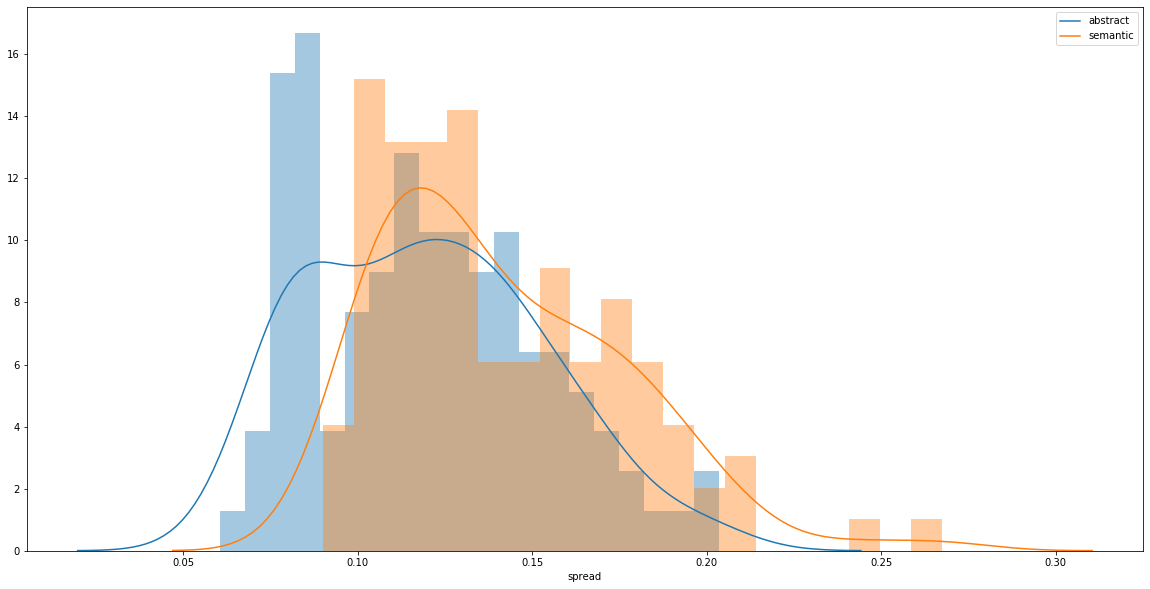

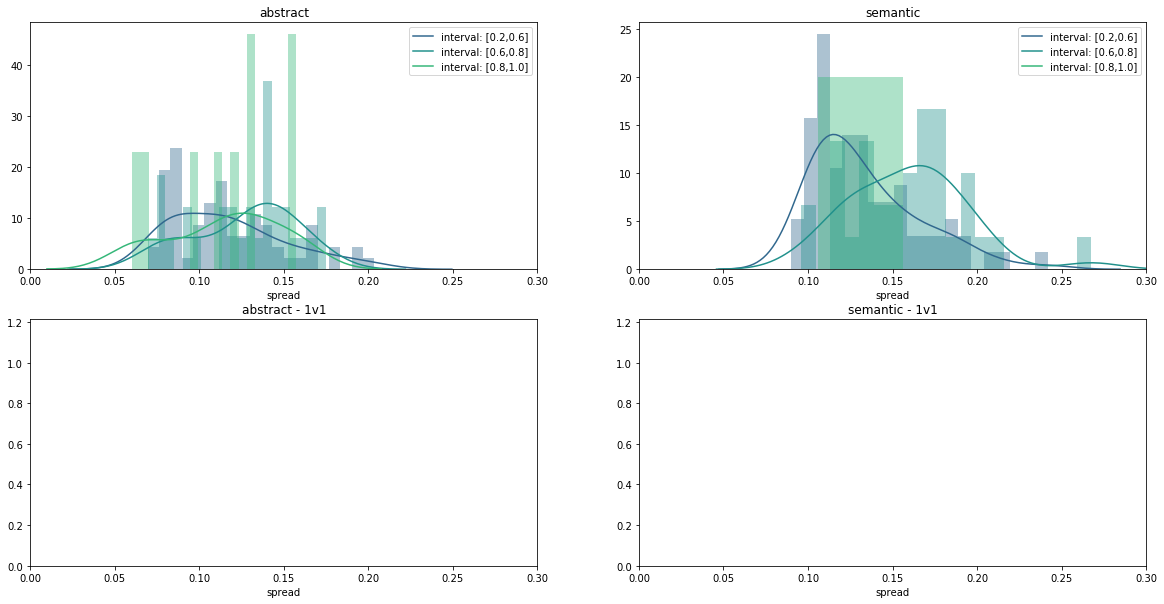

In [54]:




confidence =.95
h = df_agg['human_rating.sem'] * t.ppf((1 + confidence) / 2, df_agg['human_rating.count'] - 1)

df_agg['start'] = df_agg['human_rating.mean']-h
df_agg['end'] = df_agg['human_rating.mean']+h
df_agg['spread'] = df_agg['end'] - df_agg['start']

df1,df2,df3,df4 = get_dfs(df_agg)
dfs = [df1,df2,df3,df4]  

fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df1.spread, bins=20, kde_kws={"label": "abstract"})
sns.distplot(df2.spread, bins=20, kde_kws={"label": "semantic"})
sns.distplot(df3.spread, bins=20, kde_kws={"label": "abstract - 1v1"})
sns.distplot(df4.spread, bins=20, kde_kws={"label": "semantic - 1v1"})



intervals = [0,.2,.6,.8,1.00]
col = 'human_rating.mean'

names = ['abstract','semantic','abstract - 1v1', 'semantic - 1v1']
colors = sns.color_palette("viridis", len(intervals))


fig, ax = plt.subplots(2,2,figsize=(20,10))
for j, dd in enumerate(dfs):
    
    for i, ints in enumerate(intervals):
        if i!=len(intervals)-1:
            dd1 = dd.loc[dd[col].between(intervals[i], intervals[i+1])]
            #print('before {} - after {}'.format(len(dd), len(dd1)))
            sns.distplot(dd1.spread, bins=20, ax = ax[j//2, j%2],
                         color = colors[i],
                        kde_kws={"label": "interval: [{},{}]"
                                 .format(intervals[i], intervals[i+1])}).set_title(names[j])
            
    ax[j//2, j%2].set_xlim(0,.3)
            
        


df_agg
            

In [61]:
sns.color_palette("Oranges")

[(0.9955709342560554, 0.8907958477508651, 0.7855132641291811),
 (0.9921568627450981, 0.7769934640522875, 0.5727028066128412),
 (0.9921568627450981, 0.6280507497116494, 0.34226835832372166),
 (0.9648442906574395, 0.47100346020761247, 0.14197616301422528),
 (0.8782929642445213, 0.31990772779700116, 0.024405997693194924),
 (0.6768627450980392, 0.22089965397923875, 0.010749711649365626)]

In [86]:
s = [.1,.2,.6]
minmax_scale(s)

array([0. , 0.2, 1. ])

In [57]:
df_agg.loc[df_agg['filename'] == 'ms_interleaved_60_120_3d_0_centeredClusters_RobPCA' ]

,filename,type,1v1,phase,human_rating.mean,human_rating.count,human_rating.sem,M.first,A.first,pass.sum,as_0.1_ce.mean,as_0.1_ce.sem,start,end,spread
148,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.79025,40,0.029414,5,5,37.0,0.072607,0.00182,0.730754,0.849746,0.118991
149,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.71300,40,0.032860,5,5,35.0,0.072607,0.00182,0.646535,0.779465,0.132931


,filename,type,1v1,phase,human_rating,idx,pass,as_0.02_ce,as_0.02_cp,as_0.02_ltcc,...,knn_6.0_ltcc,knn_8.0_ce,knn_8.0_cp,knn_8.0_ltcc,index,M,A,class,human_bin,expert_bin
28045,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.78,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
28046,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.67,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
28047,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.89,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
28048,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.85,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
28049,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.63,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28180,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,1.00,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.0,...,1.0,0.019895,0.990260,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28181,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.97,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.0,...,1.0,0.019895,0.990260,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28182,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.83,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.0,...,1.0,0.019895,0.990260,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28183,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.60,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.0,...,1.0,0.019895,0.990260,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes


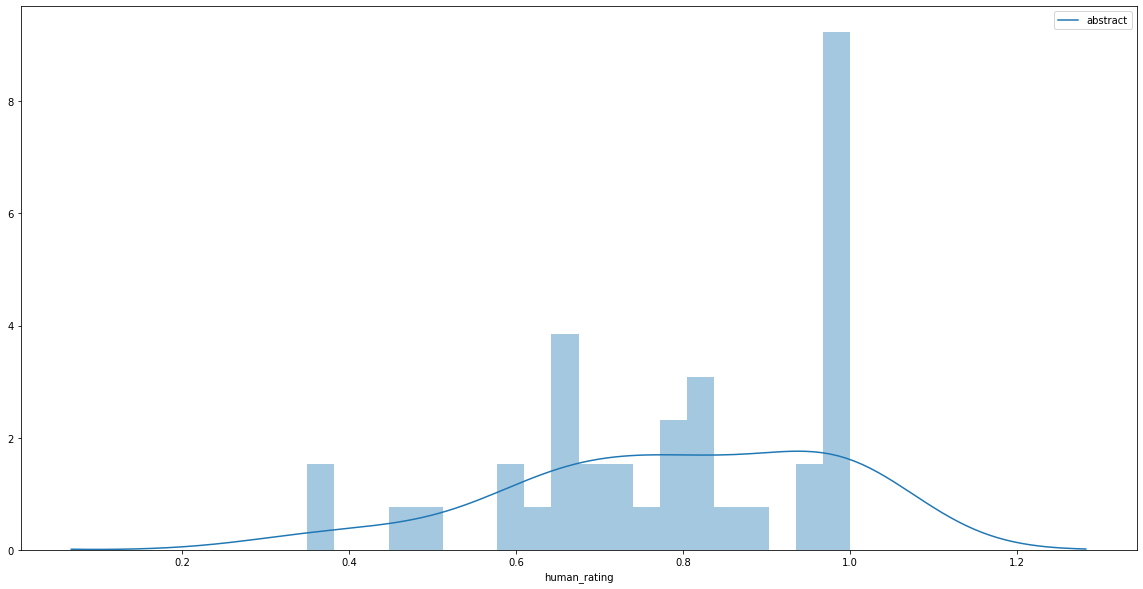

In [65]:
fig, ax = plt.subplots(figsize=(20,10))

ddd = df.loc[df['filename'] == 'ms_interleaved_60_120_3d_0_centeredClusters_RobPCA' ]


df1,df2,df3,df4 = get_dfs(ddd)
dfs = [df1,df2,df3,df4]  


sns.distplot(ddd.loc[ddd['type'] == 'abstract','human_rating' ], bins=20, kde_kws={"label": "abstract"})
#sns.distplot(ddd.loc[ddd['type'] == 'semantic','human_rating' ], bins=20, kde_kws={"label": "semantic"})

